## [필수 분석]

입점 기업별 RFM 분석(3그룹) 진행

매출 시각화

    -월별, 연도별 매출

    -월별 순수익 (처리 상황, 할부기간
고려)

결제 방법에 따른 분석

결제 방법과 결제금액의 연관성
분석

결제방법은 맨 앞의 한가지만
사용한 것으로 간주


### [선택 분석]

매출 시각화 2

최대 매출 상품 3종류 집계

주문 연도에 따른 해당 상품의
매출 증감 분석

연관성 분석

주문한 달과 판매금액의
상관관계 분석

※ 연도의 변화는 무시한다

In [27]:
import pandas as pd

df = pd.read_excel("C:/Users/minsu/Downloads/미니프로젝트-쇼핑몰 실습데이터.xlsx")


In [2]:
# '판매금액', '업체명', '주문일자' 열에 대한 결측치를 모두 제거
df2 = df.dropna(subset=['판매금액', '업체명', '주문일자'])


In [3]:
# '지니 태블릿(후불집행)'을 '지니'로 변경
df2.loc[df2['업체명'] == '지니 태블릿(후불집행)', '업체명'] = '지니'

# '지니 태블릿'을 '지니'로 변경
df2.loc[df2['업체명'] == '지니 태블릿', '업체명'] = '지니'


In [4]:
from datetime import datetime, timedelta

# '주문일자'를 날짜형식으로 변경
df['주문일자'] = pd.to_datetime(df['주문일자'])

In [5]:
import pandas as pd
from datetime import datetime

# 최근 구매일 계산
current_date = datetime(2023, 12, 26)
df2['Recency_Score'] = (current_date - pd.to_datetime(df2['주문일자'])).dt.days

# 주문일자가 최근일수록 점수가 크도록
df2['Recency'] = 1 / (1 + df2['Recency_Score'])
df2['Recency'] = df2['Recency'] / (0.00000024213)


# 빈도 계산
frequency_df = df2.groupby(['업체명'])['주문일자'].count().reset_index()
frequency_df.columns = ['업체명', 'Frequency']  # 열 이름 변경
frequency_df['Frequency'] = frequency_df['Frequency'] / 8.555

# 금액 계산
monetary_df = df2.groupby(['업체명'])['판매금액'].sum().reset_index()
monetary_df.columns = ['업체명', 'Monetary']

# Monetary 값을 천분의 1로 나타내기 위해 1000으로 나누기
monetary_df['Monetary'] = monetary_df['Monetary'] / 377968

# 열 이름 변경
monetary_df.columns = ['업체명', 'Monetary']

C:\Users\minsu\AppData\Local\Temp\ipykernel_14496\1160647201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Recency_Score'] = (current_date - pd.to_datetime(df2['주문일자'])).dt.days
C:\Users\minsu\AppData\Local\Temp\ipykernel_14496\1160647201.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Recency'] = 1 / (1 + df2['Recency_Score'])
C:\Users\minsu\AppData\Local\Temp\ipykernel_14496\1160647201.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [6]:
max_monetary_value = monetary_df['Monetary'].max()
print("Monetary 열에서 가장 큰 값:", max_monetary_value)

print("Frequency 열에서 가장 큰 값:", frequency_df['Frequency'].max())

print("Recency 열에서 가장 큰 값:", df2['Recency'].max())

Monetary 열에서 가장 큰 값: 10000.004828451085
Frequency 열에서 가장 큰 값: 10000.350672121567
Recency 열에서 가장 큰 값: 10000.0310000961


In [7]:
# Recency, Frequency, Monetary 데이터를 하나로 합치기
result_df = pd.merge(frequency_df, monetary_df, on='업체명')
result_df = pd.merge(result_df, df2.groupby('업체명').agg({'Recency': 'mean'}).reset_index(), on='업체명')

result_df

,업체명,Frequency,Monetary,Recency
0,7321디자인,9.000584,0.923888,9830.633759
1,가베,40.677966,20.890499,5079.740190
2,가이스파트너스,35.768556,48.092696,3272.819006
3,거영아이앤디,512.448860,96.786791,6234.763872
4,그린피앤에스,32.495617,7.940249,5587.360715
...,...,...,...,...
82,피플이엔티,8.182350,14.907611,3741.014031
83,한민유통,77.498539,27.591648,4469.713983
84,한샘글로벌,0.350672,0.247111,9849.009583
85,행복한바오밥,27.703098,12.969749,5044.483705


In [8]:
# RFM 가중치 설정 (가중치는 비즈니스 요구에 따라 조절 가능)
recency_weight = 0.3
frequency_weight = 0.2
monetary_weight = 0.1

In [9]:
df = pd.DataFrame(result_df)
# 가중 평균 계산
df['RFM_Score'] = (recency_weight * df['Recency'] +
                   frequency_weight * df['Frequency'] +
                   monetary_weight * df['Monetary']) / (recency_weight + frequency_weight + monetary_weight)

# RFM 등급 할당 함수
def assign_rfm_grade(score):
    high_threshold = df['RFM_Score'].quantile(2 / 3)  # 상위 3분의 1에 해당하는 값
    low_threshold = df['RFM_Score'].quantile(1 / 3)  # 하위 3분의 1에 해당하는 값
    
    if score >= high_threshold:
        return '높음'
    elif score <= low_threshold:
        return '낮음'
    else:
        return '중간'

# RFM 등급 할당
df['RFM_Grade'] = df['RFM_Score'].apply(assign_rfm_grade)

# 결과 출력
print(df[['업체명', 'RFM_Score', 'RFM_Grade']])

        업체명    RFM_Score RFM_Grade
0   7321디자인  4918.471056        높음
1        가베  2556.911167        중간
2   가이스파트너스  1656.347804        낮음
3    거영아이앤디  3304.329355        높음
4    그린피앤에스  2805.835605        중간
..      ...          ...       ...
82    피플이엔티  1875.719067        낮음
83     한민유통  2265.288446        중간
84    한샘글로벌  4924.662867        높음
85   행복한바오밥  2533.637843        중간
86    헬스하우스  3477.960227        높음

[87 rows x 3 columns]


In [10]:
df2 = pd.merge(df2, df[['업체명', 'RFM_Grade']], on='업체명', how='left')

In [11]:
low = df2[df2['RFM_Grade']=='낮음']
medium = df2[df2['RFM_Grade']=='중간']
high = df2[df2['RFM_Grade']=='높음']


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

# 주문일자를 날짜 형식으로 변환
low['주문일자'] = pd.to_datetime(low['주문일자'])
low_mon = low.resample('M', on='주문일자')['판매금액'].sum().reset_index()

medium['주문일자'] = pd.to_datetime(medium['주문일자'])
medium_mon = medium.resample('M', on='주문일자')['판매금액'].sum().reset_index()

high['주문일자'] = pd.to_datetime(high['주문일자'])
high_mon = high.resample('M', on='주문일자')['판매금액'].sum().reset_index()



C:\Users\minsu\AppData\Local\Temp\ipykernel_14496\2323767309.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low['주문일자'] = pd.to_datetime(low['주문일자'])
C:\Users\minsu\AppData\Local\Temp\ipykernel_14496\2323767309.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium['주문일자'] = pd.to_datetime(medium['주문일자'])
C:\Users\minsu\AppData\Local\Temp\ipykernel_14496\2323767309.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

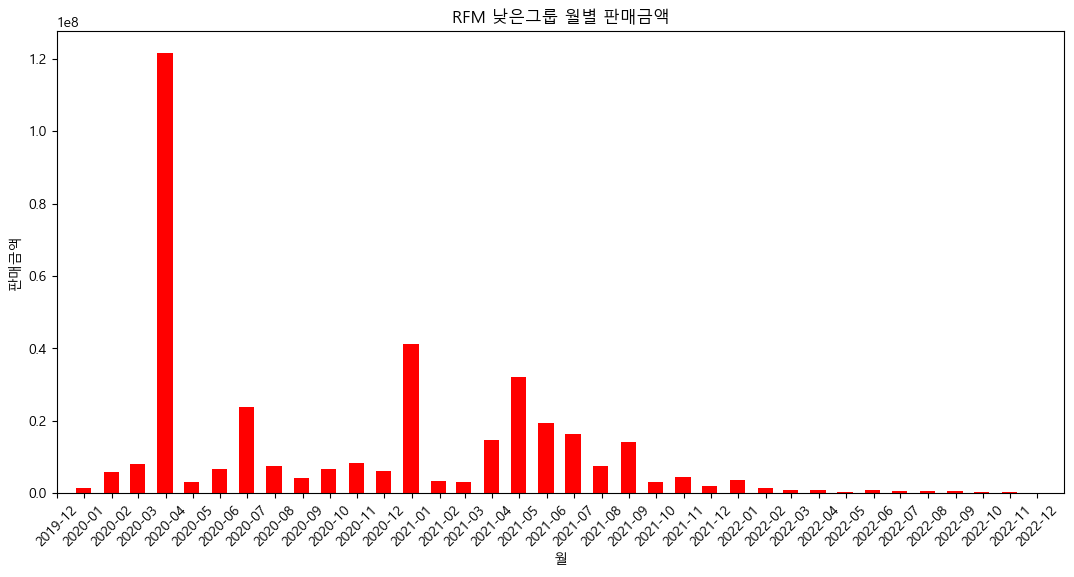

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 그래프 크기 조절
plt.figure(figsize=(13, 6))

# 한 달 단위로 x축에 표시하기 위해 Locator를 사용
locator = mdates.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)

# x축의 날짜 형식을 월-년 형식으로 지정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.bar(low_mon['주문일자'], low_mon['판매금액'], label='Low', color='red', width=17)

plt.xlim(pd.Timestamp('2019-12-01'), pd.Timestamp('2022-12-31'))

plt.title('RFM 낮은그룹 월별 판매금액')
plt.xlabel('월')
plt.ylabel('판매금액')
plt.xticks(rotation=45)  # X 축 레이블 회전
plt.show()



In [63]:
#상품명별로 금액 합산
low_bp = low.groupby('상품명')['판매금액'].sum()

# 판매금액을 높은 순으로 정렬
low_bp1 = low_bp.sort_values(ascending=False)
low_bp1.head(3)

상품명
[마감] 3D 패션 마스크 벌크-50개입          63185000
[2차앵콜!] 성인용 3D패션 마스크 벌크-50개입    51065000
[엠에프] 국산 3중필터 일회용 마스크 50매       15006200
Name: 판매금액, dtype: int64

In [65]:
#상품명별로 금액 합산
med_bp = medium.groupby('상품명')['판매금액'].sum()

# 판매금액을 높은 순으로 정렬
med_bp1 = med_bp.sort_values(ascending=False)
med_bp1.head(3)

상품명
[주간특가] 엑스포트  복사용지 A4용지 75g-1Box 2,500매입+기본 배송비 포함    44395100
[특가/무배] 한국제지 엑스포트 A4 75g 1Box 2,500매입                27554200
[특가/무배] 무림 하이브라이트 A4 75g 1Box(2,500매입)               22279800
Name: 판매금액, dtype: int64

In [66]:
#상품명별로 금액 합산
high_bp = high.groupby('상품명')['판매금액'].sum()

# 판매금액을 높은 순으로 정렬
high_bp1 = high_bp.sort_values(ascending=False)
high_bp1.head(3)

상품명
[스마트 HBE] 학습 전용 태블릿-일반결제       965844000
[신세계] 신세계 상품권-4만원권             896793600
[지사전용] 스마트 HBE-학습 전용 태블릿-후불    622908000
Name: 판매금액, dtype: int64

(array([18231., 18262., 18293., 18322., 18353., 18383., 18414., 18444.,
        18475., 18506., 18536., 18567., 18597., 18628., 18659., 18687.,
        18718., 18748., 18779., 18809., 18840., 18871., 18901., 18932.,
        18962., 18993., 19024., 19052., 19083., 19113., 19144., 19174.,
        19205., 19236., 19266., 19297., 19327.]),
 [Text(18231.0, 0, '2019-12'),
  Text(18262.0, 0, '2020-01'),
  Text(18293.0, 0, '2020-02'),
  Text(18322.0, 0, '2020-03'),
  Text(18353.0, 0, '2020-04'),
  Text(18383.0, 0, '2020-05'),
  Text(18414.0, 0, '2020-06'),
  Text(18444.0, 0, '2020-07'),
  Text(18475.0, 0, '2020-08'),
  Text(18506.0, 0, '2020-09'),
  Text(18536.0, 0, '2020-10'),
  Text(18567.0, 0, '2020-11'),
  Text(18597.0, 0, '2020-12'),
  Text(18628.0, 0, '2021-01'),
  Text(18659.0, 0, '2021-02'),
  Text(18687.0, 0, '2021-03'),
  Text(18718.0, 0, '2021-04'),
  Text(18748.0, 0, '2021-05'),
  Text(18779.0, 0, '2021-06'),
  Text(18809.0, 0, '2021-07'),
  Text(18840.0, 0, '2021-08'),
  Text(1887

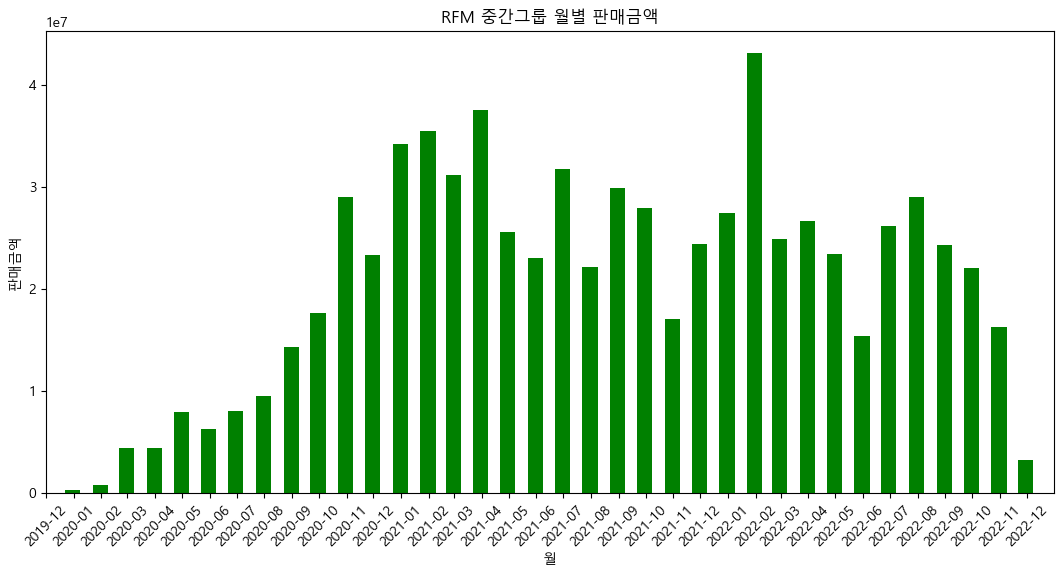

In [29]:
#그래프 크기 조절
plt.figure(figsize=(13, 6))

# 한 달 단위로 x축에 표시하기 위해 Locator를 사용
locator = mdates.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)

# x축의 날짜 형식을 월-년 형식으로 지정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.bar(medium_mon['주문일자'], medium_mon['판매금액'], label='Medium', color='green', width=17)
plt.xlim(pd.Timestamp('2019-12-01'), pd.Timestamp('2022-12-31'))
plt.title('RFM 중간그룹 월별 판매금액')
plt.xlabel('월')
plt.ylabel('판매금액')
plt.xticks(rotation=45)  # X 축 레이블 회전

(array([18231., 18262., 18293., 18322., 18353., 18383., 18414., 18444.,
        18475., 18506., 18536., 18567., 18597., 18628., 18659., 18687.,
        18718., 18748., 18779., 18809., 18840., 18871., 18901., 18932.,
        18962., 18993., 19024., 19052., 19083., 19113., 19144., 19174.,
        19205., 19236., 19266., 19297., 19327.]),
 [Text(18231.0, 0, '2019-12'),
  Text(18262.0, 0, '2020-01'),
  Text(18293.0, 0, '2020-02'),
  Text(18322.0, 0, '2020-03'),
  Text(18353.0, 0, '2020-04'),
  Text(18383.0, 0, '2020-05'),
  Text(18414.0, 0, '2020-06'),
  Text(18444.0, 0, '2020-07'),
  Text(18475.0, 0, '2020-08'),
  Text(18506.0, 0, '2020-09'),
  Text(18536.0, 0, '2020-10'),
  Text(18567.0, 0, '2020-11'),
  Text(18597.0, 0, '2020-12'),
  Text(18628.0, 0, '2021-01'),
  Text(18659.0, 0, '2021-02'),
  Text(18687.0, 0, '2021-03'),
  Text(18718.0, 0, '2021-04'),
  Text(18748.0, 0, '2021-05'),
  Text(18779.0, 0, '2021-06'),
  Text(18809.0, 0, '2021-07'),
  Text(18840.0, 0, '2021-08'),
  Text(1887

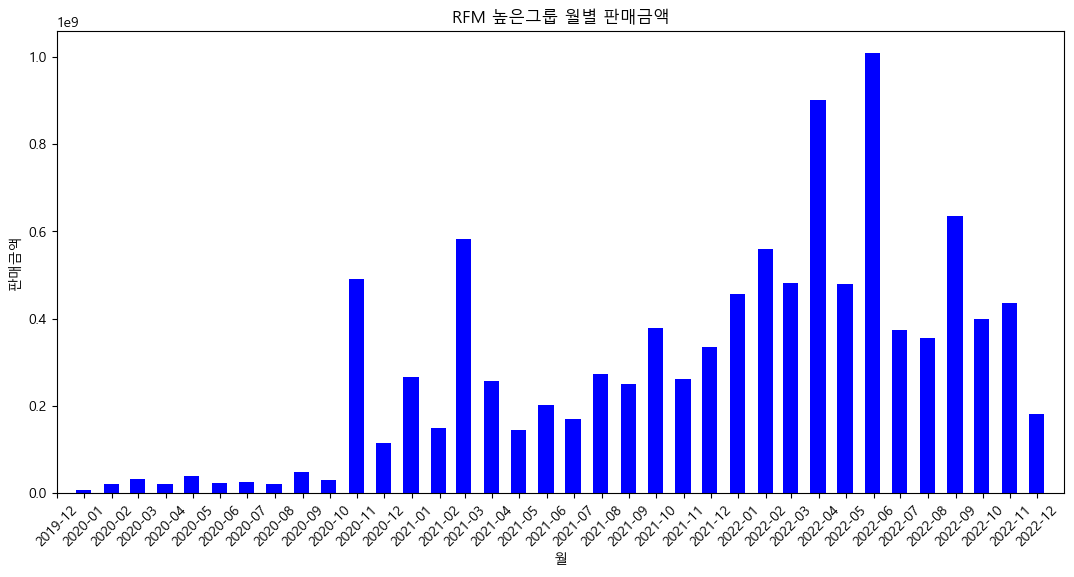

In [28]:
#그래프 크기 조절
plt.figure(figsize=(13, 6))

# 한 달 단위로 x축에 표시하기 위해 Locator를 사용
locator = mdates.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)

# x축의 날짜 형식을 월-년 형식으로 지정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlim(pd.Timestamp('2019-12-01'), pd.Timestamp('2022-12-31'))

plt.bar(high_mon['주문일자'], high_mon['판매금액'], label='High', color='blue', width=17)

plt.title('RFM 높은그룹 월별 판매금액')
plt.xlabel('월')
plt.ylabel('판매금액')
plt.xticks(rotation=45)  # X 축 레이블 회전

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


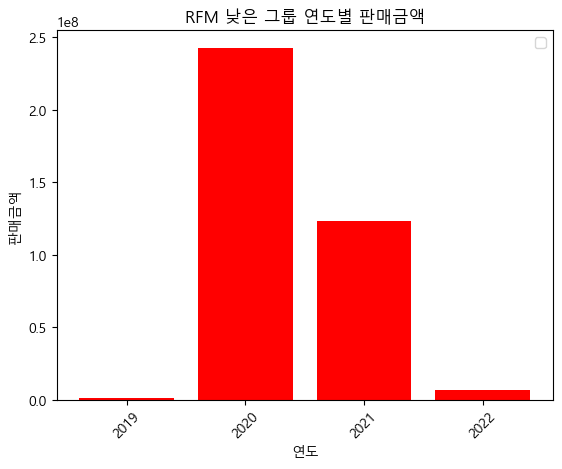

In [30]:
# 연도별로 그룹화하여 총 판매금액 계산
year_low = low.resample('Y', on='주문일자')['판매금액'].sum().reset_index()
year_medium = medium.resample('Y', on='주문일자')['판매금액'].sum().reset_index()
year_high = high.resample('Y', on='주문일자')['판매금액'].sum().reset_index()

# 주문일자를 연도로 변경
year_low['연도'] = year_low['주문일자'].dt.year
year_medium['연도'] = year_medium['주문일자'].dt.year
year_high['연도'] = year_high['주문일자'].dt.year

year_low.loc[len(year_low)] = ['2019-12-31', 0, 2019]

plt.bar(year_low['연도'], year_low['판매금액'], color = 'red')
#그래프 크기 조절



plt.title('RFM 낮은 그룹 연도별 판매금액')
plt.xlabel('연도')
plt.ylabel('판매금액')
plt.xticks(rotation=45)  # X 축 레이블 회전
# X 축 눈금 설정
plt.xticks(range(2019,2023))

plt.legend()
plt.show()

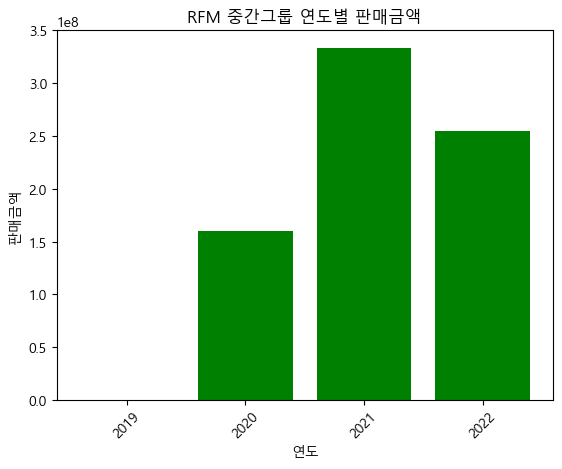

In [31]:
plt.bar(year_medium['연도'], year_medium['판매금액'], color='green')

plt.title('RFM 중간그룹 연도별 판매금액')
plt.xlabel('연도')
plt.ylabel('판매금액')
plt.xticks(rotation=45)  # X 축 레이블 회전
# X 축 눈금 설정
plt.xticks(range(2019,2023))
plt.show()

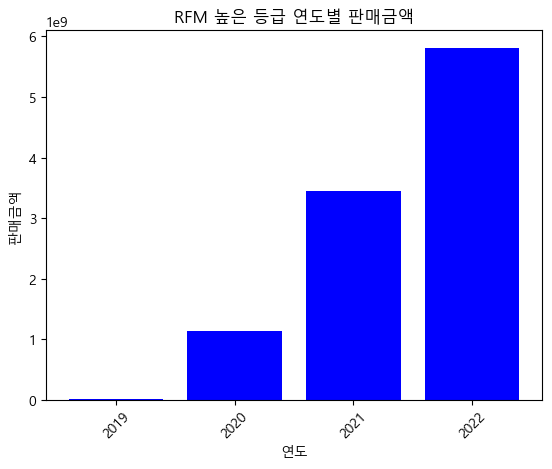

In [32]:
plt.bar(year_high['연도'], year_high['판매금액'], color='blue')

plt.title('RFM 높은 등급 연도별 판매금액')
plt.xlabel('연도')
plt.ylabel('판매금액')
plt.xticks(rotation=45)  # X 축 레이블 회전
# X 축 눈금 설정
plt.xticks(year_low['연도'].unique())
plt.xticks(range(2019,2023))
plt.show()

In [33]:
df2['처리상태'].unique()

array(['구매확정', '주문취소', '미결제', '후불반려', '환불완료', '환불승인', '부분환불', '부분취소',
       '상담취소', '교환완료', '상담형상품접수', '환불요청', '배송완료', '배송준비', '배송중', '시안확인요청',
       '결제완료'], dtype=object)

In [40]:
low_status = low[low['처리상태'].isin(['구매확정','배송완료','배송준비','배송중','결제완료'])]

In [58]:
low_status = low_status.resample('M', on='주문일자')['판매금액'].sum().reset_index()

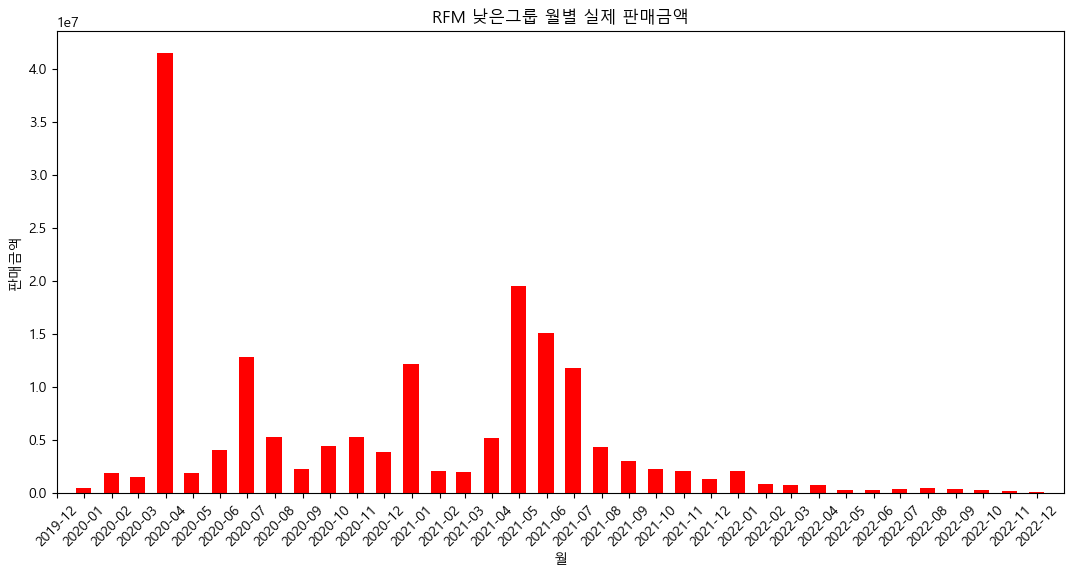

In [42]:
#그래프 크기 조절
plt.figure(figsize=(13, 6))
plt.bar(low_status['주문일자'], low_status['판매금액'], label='Low', color='red', width=17)


# 한 달 단위로 x축에 표시하기 위해 Locator를 사용
locator = mdates.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)

# x축의 날짜 형식을 월-년 형식으로 지정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlim(pd.Timestamp('2019-12-01'), pd.Timestamp('2022-12-31'))
plt.title('RFM 낮은그룹 월별 실제 판매금액')
plt.xlabel('월')
plt.ylabel('판매금액')
plt.xticks(rotation=45)  # X 축 레이블 회전
plt.show()



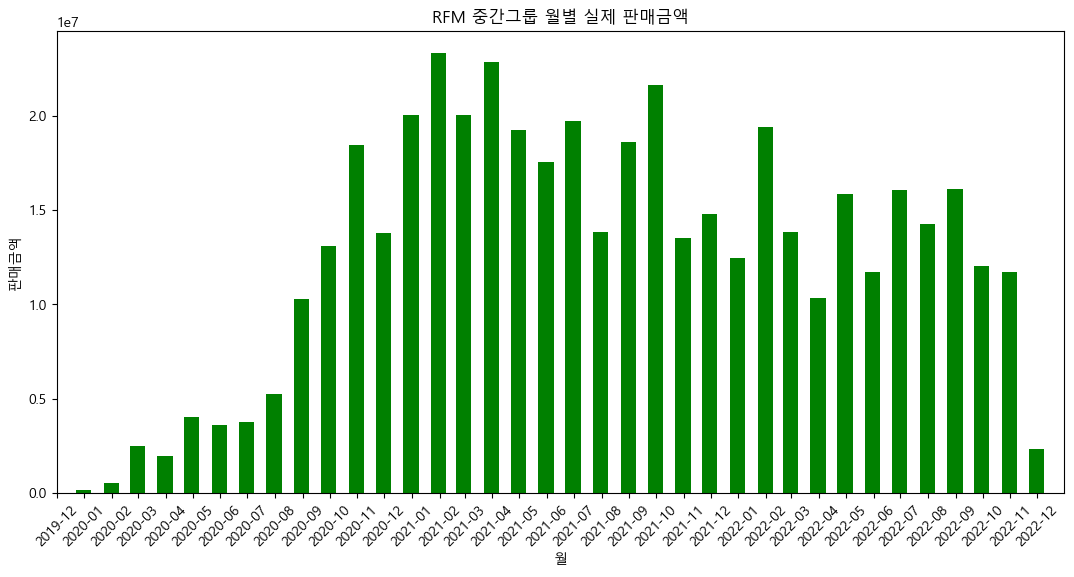

In [43]:
medium_status = medium[medium['처리상태'].isin(['구매확정','배송완료','배송준비','배송중'])]
medium_status = medium_status.resample('M', on='주문일자')['판매금액'].sum().reset_index()

#그래프 크기 조절
plt.figure(figsize=(13, 6))
plt.bar(medium_status['주문일자'], medium_status['판매금액'], label='Medium', color='green', width=17)


# 한 달 단위로 x축에 표시하기 위해 Locator를 사용
locator = mdates.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)

# x축의 날짜 형식을 월-년 형식으로 지정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlim(pd.Timestamp('2019-12-01'), pd.Timestamp('2022-12-31'))

plt.title('RFM 중간그룹 월별 실제 판매금액')
plt.xlabel('월')
plt.ylabel('판매금액')
plt.xticks(rotation=45)  # X 축 레이블 회전
plt.show()



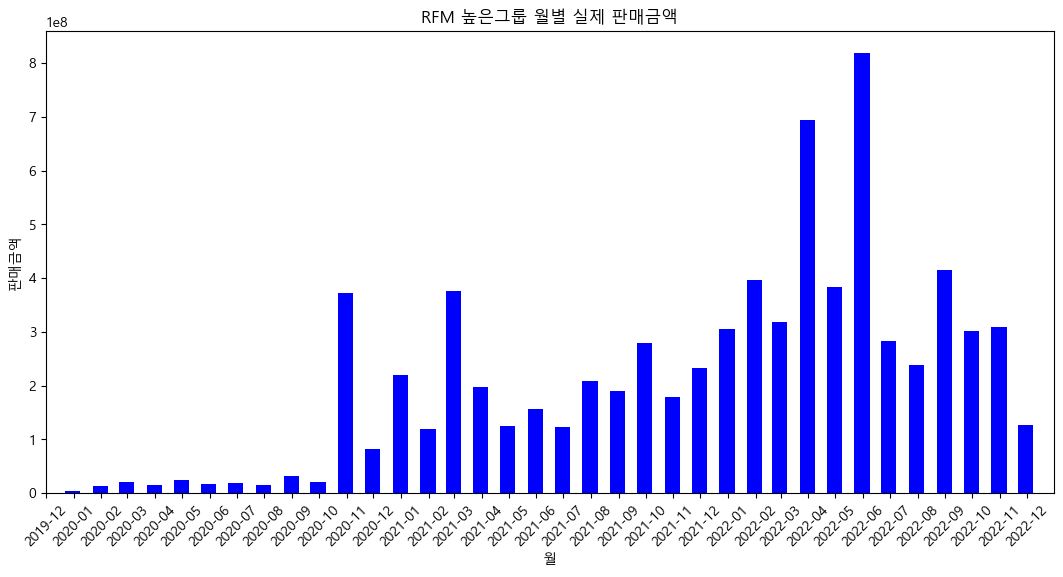

In [44]:
high_status = high[high['처리상태'].isin(['구매확정','배송완료','배송준비','배송중'])]
high_status = high_status.resample('M', on='주문일자')['판매금액'].sum().reset_index()
#그래프 크기 조절
plt.figure(figsize=(13, 6))
plt.bar(high_status['주문일자'], high_status['판매금액'], label='High', color='blue', width=17)


# 한 달 단위로 x축에 표시하기 위해 Locator를 사용
locator = mdates.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)

# x축의 날짜 형식을 월-년 형식으로 지정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlim(pd.Timestamp('2019-12-01'), pd.Timestamp('2022-12-31'))


plt.title('RFM 높은그룹 월별 실제 판매금액')
plt.xlabel('월')
plt.ylabel('판매금액')
plt.xticks(rotation=45)  # X 축 레이블 회전
plt.show()


In [61]:
#'판매금액'을 비교하여 true_low 열 생성
low_mon['difference'] = low_mon['판매금액'] - low_status['판매금액']

# true_low 값이 가장 큰 행 가져오기
max_true_low = low_mon.loc[low_mon['difference'].idxmax()]

print("낮은그룹 중에 차이가 가장 큰 달:", max_true_low)

#'판매금액'을 비교
medium_mon['difference'] = medium_mon['판매금액'] - medium_status['판매금액']

# true_low 값이 가장 큰 행 가져오기
max_true_med = medium_mon.loc[medium_mon['difference'].idxmax()]

print("중간그룹 중에 차이가 가장 큰 달:", max_true_med)


#'판매금액'을 비교
high_mon['difference'] = high_mon['판매금액'] - high_status['판매금액']

# true_low 값이 가장 큰 행 가져오기
max_true_high = high_mon.loc[high_mon['difference'].idxmax()]

print("높은그룹 중에 차이가 가장 큰 달:", max_true_high)

낮은그룹 중에 차이가 가장 큰 달: 주문일자          2020-03-31 00:00:00
판매금액                    121571620
true_low                 80103500
difference               80103500
Name: 3, dtype: object
중간그룹 중에 차이가 가장 큰 달: 주문일자          2022-01-31 00:00:00
판매금액                     43102040
difference               23691750
Name: 25, dtype: object
높은그룹 중에 차이가 가장 큰 달: 주문일자          2022-08-31 00:00:00
판매금액                    636184075
difference              221857560
Name: 32, dtype: object
